# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). 

The algorithm provides the discords of arbitrary length in time series.

## import libraries

In [2]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('stumpy.mplstyle')

# import toy data set: noisy sine wave

In [121]:
from scipy.io import loadmat

# data set is available at: 
# https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view

data = loadmat("MERLIN_data\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

## Visualizing data

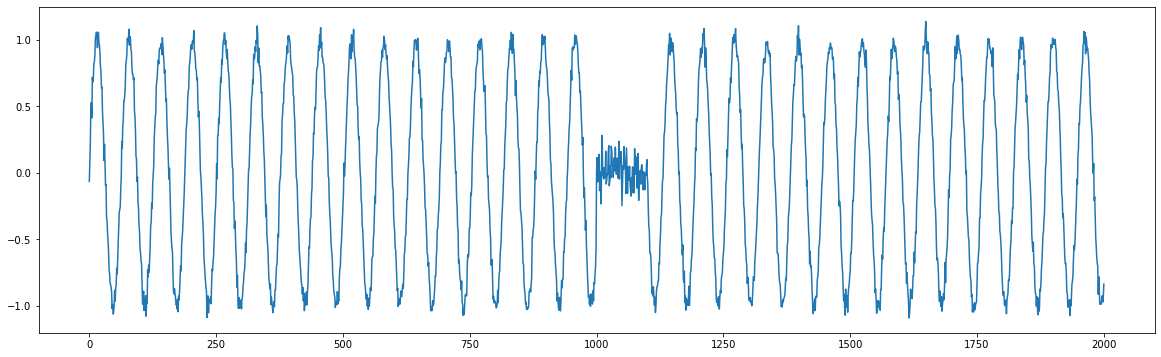

In [24]:
plt.plot(ts)
plt.show()

As depicted in the figure above, there is an anomaly in the sequence

## implemeting MERLIN algorithm

### part I: DRAG algorithm 

DRAG algorithm is a name used by the authors to refer to the algorithm proposed in [](). The DRAG aglorithm tries to find a set of discords for a user-defined r (range of discord: the threshold. A subsequence is discord if its distance to its NN is not less than r.

In [72]:
def candidate_selection_algorithm(
    T_A, 
    m, 
    r
):
    """
    For a time series T_A, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T_A: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    C: set
        a set of discords
    
    """
    z_normalize = True
    
    #create empty set
    C = set()
    
    #scan all subsequences
    for i in range(0,len(T_A)-m):
        is_candidate = True
        
        
        to_remove =  []
        for j in list(C):
            if abs(i-j)>=m: #non-trival match test
                T_i = T_A[i:(i+m)]
                T_j = T_A[j:(j+m)]
                
                T_i = stumpy.core.z_norm(T_i)
                T_j = stumpy.core.z_norm(T_j)
                
                dist = np.linalg.norm(T_i-T_j)
                if dist < r:
                    to_remove.append(j)
                    is_candidate = False
                    #break (it is in MATLAB code provided by the authoer, but that doesn't make sense!) 
        
        for rm in to_remove:
            C.remove(rm)
        
        if is_candidate:
            C.add(i)
        
    
    if len(C)==0:
        return 'failure'
    else:    
        
        return C

In [108]:
def discords_refinement_algorithm(
    T_A, 
    m, 
    r, 
    C
):
    """
    For a time series T_A, the algorithm refines a set of discords by removing the false positives,
    i.e. the subsequences whose distance from their NN is more than r. 
    
    Parameters
    ---------
    T_A: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    C: set
        the set of indices of initially-discovered discored
    
    
    output
    --------
    D: ndarray
        a 2d array where the first axis corresponds to the discords, and the second axis contains information for each discord
        
    
    ind_to_remove: ndarray
        an array that contains the indices that need to be removed from D.
    """
    C_lst = list(C)
    
    D = np.zeros((len(C_lst),4)) #D[i]: [discord index, discord NN, length of subsequence, distance to NN] 
    D[:,0] = np.array(C_lst)
    D[:,1] = 0
    D[:,2] = m
    D[:,3] = float('inf')
    
    C_indices_tot = np.arange(len(C_lst))
    
    C_indices = C_indices_tot[:]
    ind_to_remove =  []
    for i in range(0, len(T_A)-m):
        if len(C_indices)==0:
            break
        
        is_discord = True
    
        for j_ind in C_indices:
            j = C_lst[j_ind]
            if abs(i-j)>=m:
                T_i = T_A[i:(i+m)]
                T_j = T_A[j:(j+m)]
                
                T_i = stumpy.core.z_norm(T_i)
                T_j = stumpy.core.z_norm(T_j)
                
                dist = np.linalg.norm(T_i-T_j)
                if dist<r:
                    D[j_ind,1] = -1
                    ind_to_remove.append(j_ind)
                    is_discord = False
                    
                else:
                    if dist<D[j_ind,-1]:
                        D[j_ind,1] = i
                    D[j_ind,0] = j
                    D[j_ind,-1] = min(D[j_ind,-1], dist)
                    
        
        C_indices = np.delete(C_indices_tot, ind_to_remove)
        
    return D, ind_to_remove

In [119]:
#testing DRAG algorithm on noisy sine wave toy data set:

T = ts[:]
m = 512 #one day as the length of subsequence
r = 10.27

C = candidate_selection_algorithm(T, m, r)
D, ind_to_remove = discords_refinement_algorithm(T, m, r, C)

D_revised = np.delete(D, ind_to_remove, axis=0)
discord_score = D_revised[:,-1]

In [120]:
#obtaining the top-k discords using DRAG
index_of_descending_sorted = np.argsort(discord_score)[::-1]

#top-k
k=10

print('                 Discord index...NN index...subsequence len....distance_to_NN')
for i in range(k):
    ind = index_of_descending_sorted[i]
    print(f'the discord #{i+1} info: {D_revised[ind,:]}')

                 Discord index...NN index...subsequence len....distance_to_NN
the discord #1 info: [938.         310.         512.          10.43901493]
the discord #2 info: [939.         311.         512.          10.43772129]
the discord #3 info: [937.         309.         512.          10.43609406]
the discord #4 info: [ 844.        1409.         512.          10.4332204]
the discord #5 info: [940.        312.        512.         10.4331267]
the discord #6 info: [781.         153.         512.          10.43298467]
the discord #7 info: [ 843.         1408.          512.           10.43236785]
the discord #8 info: [875.         247.         512.          10.43159954]
the discord #9 info: [845.         217.         512.          10.43080349]
the discord #10 info: [936.         308.         512.          10.43072833]
